## Importing Libraries

In [1]:
# data manipulating library
import numpy as np
import pandas as pd

# plotting library
import matplotlib.pyplot as plt
import seaborn as sns

import os
import pandas as pd
import spacy
import re
import nltk
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from rake_nltk import Rake

import warnings
warnings.filterwarnings("ignore")


## Data Loading

In [2]:
FILE_PATH = r"./src/data/raw_analyst_ratings.csv"

def load_data(file_path=FILE_PATH):
    """
    Load the analyst ratings data from a CSV file.
    
    Parameters:
    file_path (str): The path to the CSV file containing the data.
    
    Returns:
    pd.DataFrame: A DataFrame containing the analyst ratings data.
    """
    try:
        data = pd.read_csv(file_path)
        return data
    except FileNotFoundError as e:
        print(f"File not found: {file_path}")
        print(e)
        return None
    

df = load_data()
if df is not None:
    print("Data loaded successfully.")
else:
    print("Failed to load data.")

Data loaded successfully.


## Data Cleaning 

* **Check for Missing Data:**  
    Identify columns with missing values and assess their impact on analysis.

* **Check for Duplicated Rows:**  
    Detect and quantify duplicate entries to ensure data integrity.

* **Check for Consistency:**  
    Verify that data types, formats, and values are consistent across all columns.


In [3]:
# missing values
def check_missing_values(df):
    """
    Check for missing values in the DataFrame.
    
    Parameters:
    df (pd.DataFrame): The DataFrame to check for missing values.
    
    Returns:
    pd.Series: A Series containing the count of missing values for each column.
    """
    if df is None:
        print("DataFrame is None, cannot check for missing values.")
        return None
    return df.isnull().sum()

missing_values = check_missing_values(df)
if missing_values is not None:
    print("Missing values in each column:")
    print(missing_values)
else:
    print("Failed to check for missing values due to None DataFrame.")

Missing values in each column:
Unnamed: 0    0
headline      0
url           0
publisher     0
date          0
stock         0
dtype: int64


In [4]:
# check duplication 

def check_duplicates(df):
    """
    Check for duplicate rows in the DataFrame.
    
    Parameters:
    df (pd.DataFrame): The DataFrame to check for duplicates.
    
    Returns:
    int: The number of duplicate rows in the DataFrame.
    """
    if df is None:
        print("DataFrame is None, cannot check for duplicates.")
        return None
    try:
        duplicates = df.duplicated().sum()
        return duplicates
    except Exception as e:
        print(f"Error checking for duplicates: {e}")
        return None
    
duplicates = check_duplicates(df)
if duplicates is not None:
    print(f"Number of duplicate rows: {duplicates}")
else:
    print("Failed to check for duplicates due to None DataFrame.")

Number of duplicate rows: 0


* This section examines whether each article URL in the dataset is unique, ensuring there are no duplicate news entries based on the `url` field.

In [5]:
def check_duplicates_based(df, url_column='url'):
    """
    Check for duplicate URLs in the DataFrame.
    
    Parameters:
    df (pd.DataFrame): The DataFrame to check for duplicate URLs.
    url_column (str): The name of the column containing URLs.
    
    Returns:
    int: The number of duplicate URLs in the DataFrame.
    """
    if df is None or url_column not in df.columns:
        print("DataFrame is None or URL column does not exist.")
        return None
    try:
        duplicates = df[url_column].duplicated().sum()
        return duplicates
    except Exception as e:
        print(f"Error checking for duplicate URLs: {e}")
        return None
    
duplicates_url = check_duplicates_based(df)

if duplicates_url is not None:
    print(f"Number of duplicate URLs: {duplicates_url}")
else:
    print("Failed to check for duplicate URLs due to None DataFrame or missing URL column.")

Number of duplicate URLs: 523899


* From the analysis above, we found that there are approximately `523,899` duplicate URLs in the dataset. This indicates that many news articles share the same URL, suggesting repeated or syndicated content. Identifying and handling these duplicates is important to ensure the integrity and uniqueness of the news data for further analysis.

In [6]:
check_duplicates_based(df, 'headline')

561558

## **Descriptive Statistics:**
* Obtain basic statistics for textual lengths (like headline length).
* Count the number of articles per publisher to identify which publishers are most active.
* Analyze the publication dates to see trends over time, such as increased news frequency on particular days or during specific events.

In [7]:
df.columns.to_list()

['Unnamed: 0', 'headline', 'url', 'publisher', 'date', 'stock']

In [8]:
# descriptive statistics
def descriptive_statistics(df):
    """
    * Obtain basic statistics for textual lengths (like headline length).
    * Count the number of articles per publisher to identify which publishers are most active.
    * Analyze the publication dates to see trends over time, such as increased news 
      frequency on particular days or during specific events.
    """
    # Check if the DataFrame is empty
    if df.empty:
        print("DataFrame is empty.")
        return
    
    # Basic statistics for textual lengths
    if 'headline' in df.columns:
        df['headline_length'] = df['headline'].apply(lambda x: len(str(x)))
        print("Headline Length Statistics:")
        print(df['headline_length'].describe())
    else:
        print("Column 'headline' not found in DataFrame.")
        
    # Count the number of articles per publisher
    if 'publisher' in df.columns:
        publisher_counts = df['publisher'].value_counts()
        print("\nNumber of articles per publisher:")
        print(publisher_counts)
    else:
        print("Column 'publisher' not found in DataFrame.")
    
descriptive_statistics(df)

Headline Length Statistics:
count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64

Number of articles per publisher:
publisher
Paul Quintaro                      228373
Lisa Levin                         186979
Benzinga Newsdesk                  150484
Charles Gross                       96732
Monica Gerson                       82380
                                    ...  
Shazir Mucklai - Imperium Group         1
Laura Jennings                          1
Eric Martin                             1
Jose Rodrigo                            1
Jeremie Capron                          1
Name: count, Length: 1034, dtype: int64


### The structure of the data is as follows
* `headline`: Article release headline, the title of the news article, which often includes key financial 
actions like stocks hitting highs, price target changes, or company earnings.
* `url`: The direct link to the full news article.
* `publisher`: Author/creator of article.
* `date`: The publication date and time, including timezone information(UTC-4 timezone).
* `stock`: Stock ticker symbol (unique series of letters assigned to a publicly traded company). For example (AAPL: Apple)

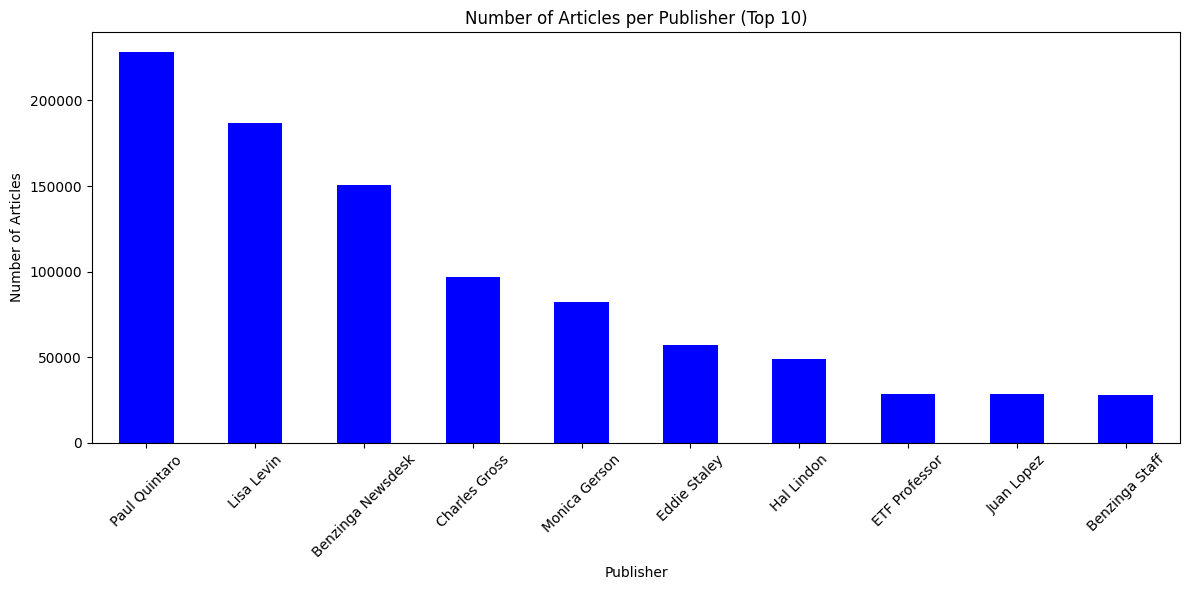

In [9]:
df["publisher"].value_counts().head(10).plot(kind='bar', figsize=(12, 6), color='blue')
plt.title("Number of Articles per Publisher (Top 10)")
plt.xlabel("Publisher")
plt.ylabel("Number of Articles")
plt.xticks(rotation=45)
plt.tight_layout()
save_dir = os.path.join("notebooks", "graph_reports")
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "articles_per_publisher.png")

plt.savefig(save_path)
plt.show()

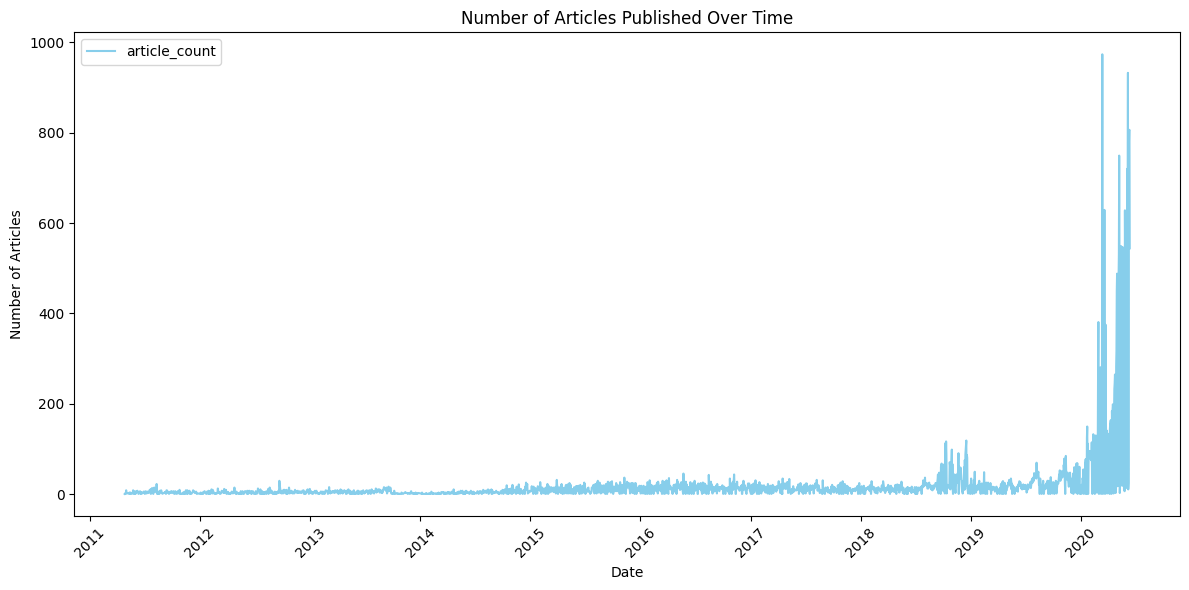

In [10]:
"""
* Analyze the publication dates to see trends over time, such as increased news frequency on particular days or during specific events.
"""

def analyze_publication_dates(df):
    """
    Analyze the publication dates to see trends over time.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the analyst ratings data.
    
    Returns:
    None
    """
    if 'date' not in df.columns:
        print("Column 'publication_date' not found in DataFrame.")
        return
    
    # Convert 'date' column to datetime format
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    
    df_copy = df.copy()
    try:
    # group by date and count the number of articles
        df_copy['to_date'] = df_copy['date'].dt.date
        articles_per_day = df_copy.groupby('to_date').size().reset_index(name='article_count')
        articles_per_day.set_index('to_date', inplace=True)
        articles_per_day.sort_index(inplace=True)
        articles_per_day.plot(kind='line', figsize=(12, 6), color='skyblue')
        plt.title("Number of Articles Published Over Time")
        plt.xlabel("Date")
        plt.ylabel("Number of Articles")
        plt.xticks(rotation=45)
        plt.tight_layout()
        save_dir = os.path.join("notebooks", "graph_reports")
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, "articles_per_day.png")
        plt.savefig(save_path)
        plt.show()
    except Exception as e:
        print("Error while analyzing publication dates:", e)
        return
    
analyze_publication_dates(df)

* Based on the plot above, we observe that the number of publications per day has generally increased over time. This trend may indicate growing media coverage or heightened market activity in recent years. Peaks in publication frequency could correspond to significant financial events or periods of increased market volatility. Analyzing these trends can help identify periods of heightened news activity and their potential impact on market sentiment.

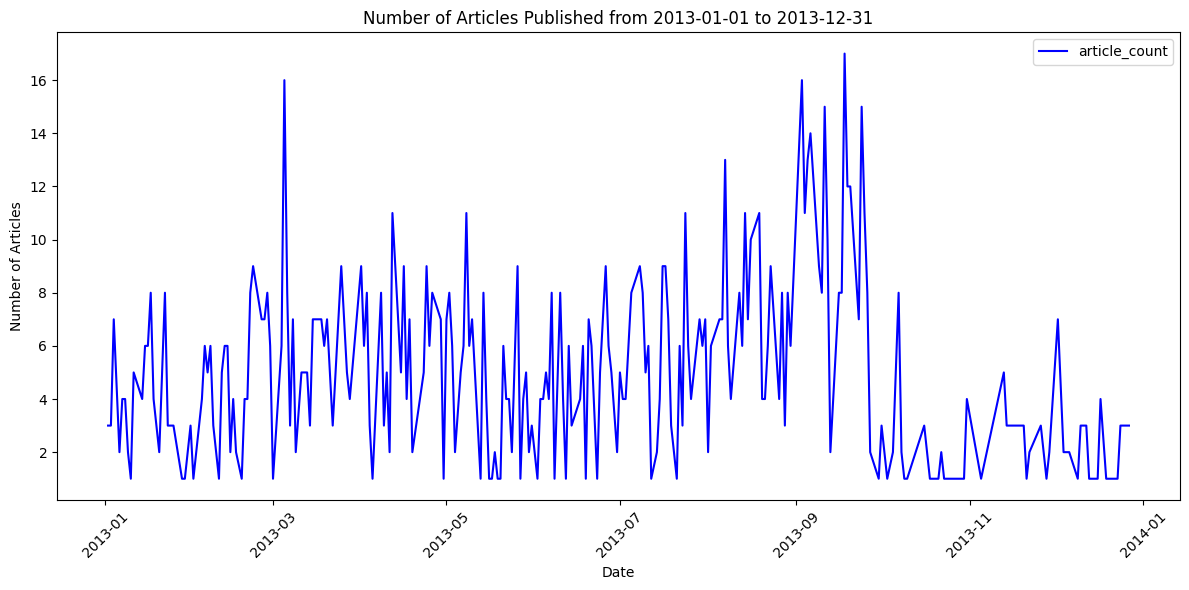

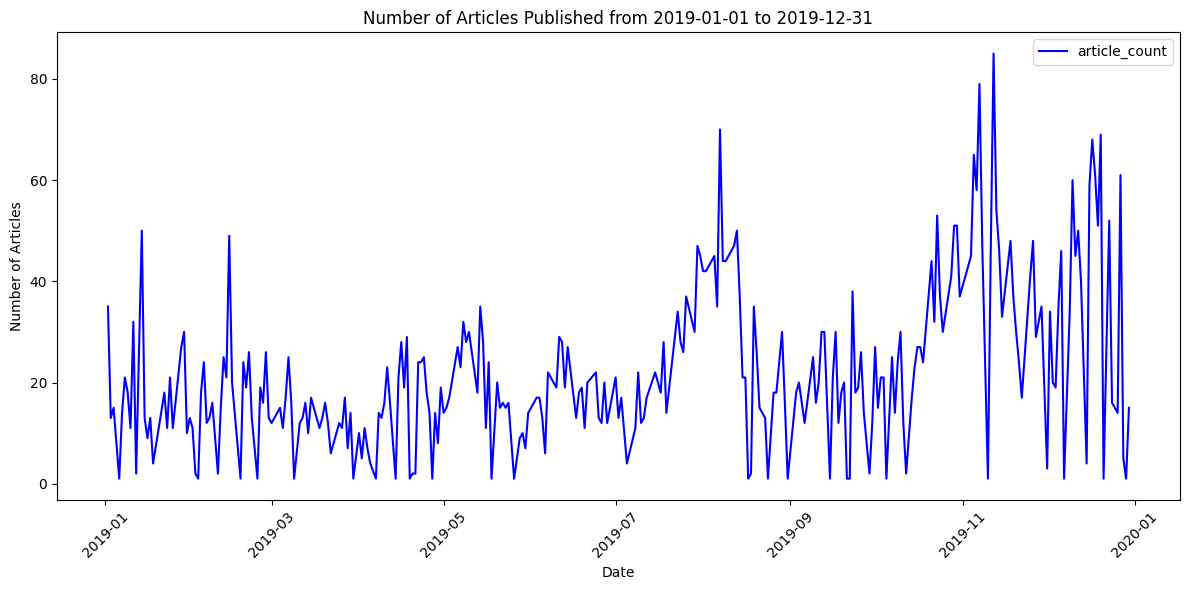

In [11]:
def analyze_publication_dates_timeframe(df, start_date, end_date):
    if 'date' not in df.columns:
        print("Column 'date' not found in DataFrame.")
        return
    # Convert 'date' column to datetime format (keep timezone info)
    df['date'] = pd.to_datetime(df['date'], errors='coerce', utc=True).dt.tz_convert('America/New_York')
    
    try:
        # Make start_date and end_date timezone-aware
        if isinstance(start_date, str):
            start_date = pd.to_datetime(start_date).tz_localize('America/New_York')
        if isinstance(end_date, str):
            end_date = pd.to_datetime(end_date).tz_localize('America/New_York')
            
        if start_date > end_date:
            print("Start date must be earlier than end date.")
            return
        
        filtered_df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]
        if filtered_df.empty:
            print("No data available for the specified date range.")
            return
        filtered_df['to_date'] = filtered_df['date'].dt.date
        articles_per_day = filtered_df.groupby('to_date').size().reset_index(name='article_count')
        articles_per_day.set_index('to_date', inplace=True)
        articles_per_day.sort_index(inplace=True)
        articles_per_day.plot(kind='line', figsize=(12, 6), color='blue')
        plt.title(f"Number of Articles Published from {start_date.date()} to {end_date.date()}")
        plt.xlabel("Date")
        plt.ylabel("Number of Articles")
        plt.xticks(rotation=45)
        plt.tight_layout()
        save_dir = os.path.join("notebooks", "graph_reports")
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, f"articles_per_day_timeframe_startdate={start_date.date()}_enddate={end_date.date()}.png")
        plt.savefig(save_path)
        plt.show()
        
    except Exception as e:
        print("Error in date conversion or filtering. Please check the date format.")
        print(e)
        return

# Example usage of the function
analyze_publication_dates_timeframe(df, '2013-01-01', '2013-12-31')
analyze_publication_dates_timeframe(df, '2019-01-01', '2019-12-31')

## Text Analysis(Topic Modeling):

Use natural language processing to identify common keywords or phrases, potentially extracting topics or significant events (like "FDA approval", "price target", etc.).

In [15]:
# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

class TextNewsAnalyzer:
    def __init__(self, num_topics=3, top_n_words=8):
        self.num_topics = num_topics
        self.top_n_words = top_n_words
        self.rake = Rake(min_length=2, max_length=4, ranking_metric="degree")
        self.event_patterns = {
            'approval': r'\b(approv(e|al)|clear(ance)?|authori(zation|ze))\b',
            'merger': r'\b(merg(e|er)|acquis(ition|e)|takeover|buyout)\b',
            'earnings': r'\b(earn(ings)?|profit|revenue|eps|income|loss)\b',
            'litigation': r'\b(sue|lawsuit|settle(ment)?|court|litigation)\b',
            'partnership': r'\b(partner(ship)?|collab(oration)?|joint venture|alliance)\b',
            'product_launch': r'\b(launch|release|unveil|introduce|roll out)\b',
            'price_target': r'\b(price target|valuation|revised target|analyst estimate)\b',
            'stock_upgrade_downgrade': r'\b(upgrad(e|ed)|downgrad(e|ed)|buy rating|sell rating|hold rating)\b',
            'ipo': r'\b(IPO|initial public offering|go public|public debut)\b',
            'dividend': r'\b(dividend|payout|distribution|yield)\b',
            'layoff': r'\b(layoff|cut jobs|job cut|workforce reduction|redundancy)\b',
            'executive_change': r'\b(CEO|CFO|executive|leadership|management|appoint(ed)?|resign(ed)?|step down)\b',
            'regulation': r'\b(regulation|SEC|antitrust|compliance|fine|ban|investigation|probe)\b',
            'market_movement': r'\b(rise|fell|plunge|soar|drop|climb|rally|dip|gain|decline|surge|tumble)\b',
            'bankruptcy': r'\b(bankrupt(cy)?|chapter 11|insolvency|restructure|debt relief)\b',
            'forecast': r'\b(forecast|guidance|outlook|project(ed)?|estimate)\b'
        }

    def _preprocess(self, text):
        """Preprocess text using spaCy"""
        try:
            doc = nlp(text)
            tokens = [
                token.lemma_.lower() for token in doc
                if not token.is_stop and not token.is_punct
                and token.pos_ in ['NOUN', 'PROPN', 'VERB', 'ADJ', 'NUM']
            ]
            return ' '.join(tokens)
        except Exception as e:
            print(f"Error processing text: {text}\nError: {str(e)}")
            return ""

    def extract_key_phrases(self, text):
        """RAKE key phrase extraction"""
        try:
            self.rake.extract_keywords_from_text(text)
            phrases = self.rake.get_ranked_phrases()[:3]
            return [p for p in phrases if len(p.split()) <= 4]
        except:
            return []

    def detect_events(self, text):
        """Detect financial/business events using regex patterns"""
        detected = []
        for event_type, pattern in self.event_patterns.items():
            if re.search(pattern, text, re.IGNORECASE):
                detected.append(event_type)
        return detected

    def label_topic(self, top_words):
        """Infer topic name from frequent terms"""
        labels = {
            'drug': 'Pharmaceutical Development',
            'approval': 'Regulatory Approval',
            'earn': 'Financial Performance',
            'merge': 'Corporate M&A',
            'lawsuit': 'Legal Matters',
            'tech': 'Technology News',
            'product': 'Product Launch',
            'dividend': 'Dividend Updates',
            'ipo': 'Market IPOs',
            'forecast': 'Market Forecast'
        }
        
        for word in top_words:
            for key, label in labels.items():
                if key in word:
                    return label
                
        return "General Business"

    def analyze_sentiment(self, text):
        """Determine polarity: positive, negative, or neutral"""
        polarity = TextBlob(text).sentiment.polarity
        if polarity > 0.1:
            return "Positive", polarity
        elif polarity < -0.1:
            return "Negative", polarity
        else:
            return "Neutral", polarity

    def analyze_topics(self, news_series):
        """Run full pipeline: preprocessing, topic modeling, event/sentiment extraction"""
        processed_texts = news_series.apply(self._preprocess)

        vectorizer = TfidfVectorizer(
            ngram_range=(1, 3),
            max_features=5000,
            stop_words='english'
        )
        
        tfidf_matrix = vectorizer.fit_transform(processed_texts)

        lda = LatentDirichletAllocation(
            n_components=self.num_topics,
            random_state=42,
            learning_method='online'
        )
        lda.fit(tfidf_matrix)

        feature_names = vectorizer.get_feature_names_out()
        topics = []
        for topic_idx, topic in enumerate(lda.components_):
            top_features = [feature_names[i] for i in topic.argsort()[:-self.top_n_words - 1:-1]]
            label = self.label_topic(top_features)
            topics.append((f"Topic {topic_idx + 1} ({label})", top_features))

        results = {
            'topics': topics,
            'events': [self.detect_events(text) for text in news_series],
            'key_phrases': [self.extract_key_phrases(text) for text in news_series],
            'sentiments': [self.analyze_sentiment(text) for text in news_series],
            'processed_texts': processed_texts.tolist()
        }

        return results
temp_df = df[["headline"]]
analyzer = TextNewsAnalyzer(num_topics=5)
results = analyzer.analyze_topics(temp_df["headline"])

KeyboardInterrupt: 

In [ ]:

results.head(10)

## Time Series Analysis: Publication Frequency Over Time
**🎯 Goals:**
* Understand how often news articles are published over time (daily, weekly, hourly).
* Detect spikes around major events (e.g., earnings season, IPOs, regulation changes).
* Determine peak publishing hours — important for algorithmic trading.

### 📊 Analysis Ideas:
**a. Publication Frequency Over Time**


In [ ]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Daily publication count
daily_counts = df.resample('D').size()

# Plot
import matplotlib.pyplot as plt
daily_counts.plot(title='Daily News Publication Frequency', figsize=(12, 5))
plt.xlabel("Date")
plt.ylabel("Article Count")
plt.grid(True)
plt.show()


**b. Weekly/Monthly Aggregation (to observe trends)**

In [ ]:
df_copy = df.copy()
df_copy.resample('W').size().plot(title='Weekly News Volume', figsize=(12, 5))

**c. Hourly Patterns**

df['hour'] = df.index.hour
df['hour'].value_counts().sort_index().plot(kind='bar', title='News Publication by Hour of Day')


### 🧠 Bonus: Overlay Market Events

# Assuming you detected events in a column `df['events']`
df['event_count'] = df['events'].apply(len)
df['event_count'].resample('D').sum().plot(label='Events')
daily_counts.plot(secondary_y=True, label='Articles', color='gray', alpha=0.5)

## ✅ 2. Publisher Analysis
**🎯 Goals:**
* Identify top news contributors.

* Detect differences in news type or sentiment by publisher.

* If emails are used as names, extract domain-level organization info.

In [ ]:
df['publisher'].value_counts().head(10).plot(kind='bar', title='Top 10 News Publishers')

**b. Publisher vs Event Types**

In [ ]:
from collections import Counter
import pandas as pd

# Explode multiple events per article
df_exploded = df.explode('events')
pivot = pd.crosstab(df_exploded['publisher'], df_exploded['events'])

# Plot heatmap
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.heatmap(pivot, cmap="Blues", annot=True, fmt='d')
plt.title("Event Type Frequency per Publisher")
plt.xlabel("Event Type")
plt.ylabel("Publisher")
plt.tight_layout()
plt.savefig(r"reports/event_type_frequency_per_publisher.png")
plt.show()

**c. Publisher Domains from Email**

In [ ]:
if '@' in df['publisher'].iloc[0]:
    df['publisher_domain'] = df['publisher'].str.extract(r'@([\w\.-]+)')

**d. Sentiment by Publisher**

In [ ]:
sentiment_df = pd.DataFrame(df['sentiment'].tolist(), columns=['label', 'score'])
df = pd.concat([df, sentiment_df], axis=1)

df.groupby('publisher')['score'].mean().sort_values().plot(kind='barh', title='Avg Sentiment Score by Publisher')